In [5]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

import pickle as pkl
import os


In [6]:
#import train dataframe
train_df = pd.read_csv('train_airbnb_berlin.csv')
train_df.head()


,Listing ID,Listing Name,Host ID,Host Name,Host Since,Host Response Time,Host Response Rate,Is Superhost,neighbourhood,Neighborhood Group,...,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Instant Bookable,Business Travel Ready,Price
0,19665213.0,*,156079597.0,Maximilian,2016-01-20,NaN,NaN,f,Prenzlauer Berg,Pankow,...,100.0,10.0,10.0,10.0,10.0,9.0,10.0,t,f,26.0
1,6436842.0,*,5302290.0,Dulie,2013-04-07,NaN,NaN,f,Pankow,Pankow,...,90.0,9.0,9.0,10.0,10.0,9.0,10.0,f,f,41.0
2,10559468.0,*,59151456.0,Geank,2016-02-07,NaN,NaN,f,Prenzlauer Berg,Pankow,...,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,50.0
3,27215482.0,*,193452785.0,Alix,2018-06-26,NaN,NaN,f,Friedrichshain,Friedrichshain-Kreuzberg,...,100.0,10.0,10.0,10.0,10.0,10.0,9.0,f,f,50.0
4,27287546.0,*,205870244.0,Lurina,2013-05-16,within a few hours,92%,t,Prenzlauer Berg,Pankow,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,f,55.0


## Data Prepration

### Remove useless columns

In [7]:
#drop unneeded columns in prediction
removal_columns =['Listing ID','Listing Name','Host ID','Host Name','neighbourhood',
                'City','Country Code','Country' ,'Host Since' ,'First Review','Last Review',
                'Business Travel Ready','Host Response Time','Host Response Rate','Postal Code','Is Exact Location',
                'Min Nights','Square Feet']
train_df.drop(columns=removal_columns,inplace=True)

### Missing Data Handlinig

In [8]:
null_values = train_df.isnull().sum()
null_coumn = train_df.columns[null_values != 0]
print('null column with number of missid values :')
print(null_values[null_values > 0])

null column with number of missid values :
Is Superhost              23
Bathrooms                 14
Bedrooms                   5
Beds                       8
Overall Rating          2962
Accuracy Rating         2971
Cleanliness Rating      2970
Checkin Rating          2973
Communication Rating    2970
Location Rating         2971
Value Rating            2972
Price                      9
dtype: int64


In [9]:
train_df.shape

(15692, 21)

In [10]:
#drop empty row  
train_df.dropna(subset=['Price'],inplace=True)
#i can't fill with mean beacuse therer is many missing in that coulumns
train_df.dropna(subset=['Overall Rating','Accuracy Rating', 'Cleanliness Rating', 'Checkin Rating', 'Communication Rating', 'Location Rating', 'Value Rating'],inplace=True,how='all')


In [11]:

#replace numerical columns missing data with tha median
for col in train_df.columns:
    train_df[col].replace('*',np.nan,inplace=True)
    # train_df[col].replace('Other',np.nan,inplace=True)
to_num_col =['Bathrooms','Bedrooms','Guests Included','Beds','Accomodates']
for c in to_num_col:
  train_df[c]=pd.to_numeric(train_df[c], downcast="float")

train_df.fillna(train_df.median(), inplace=True)
                         


C:\Users\ahmed\AppData\Local\Temp\ipykernel_16040\3700358088.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_df.fillna(train_df.median(), inplace=True)


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12728 entries, 0 to 15690
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Is Superhost          12717 non-null  object 
 1   Neighborhood Group    12728 non-null  object 
 2   Latitude              12728 non-null  float64
 3   Longitude             12728 non-null  float64
 4   Property Type         12672 non-null  object 
 5   Room Type             12728 non-null  object 
 6   Accomodates           12728 non-null  float32
 7   Bathrooms             12728 non-null  float32
 8   Bedrooms              12728 non-null  float32
 9   Beds                  12728 non-null  float32
 10  Guests Included       12728 non-null  float32
 11  Reviews               12728 non-null  int64  
 12  Overall Rating        12728 non-null  float64
 13  Accuracy Rating       12728 non-null  float64
 14  Cleanliness Rating    12728 non-null  float64
 15  Checkin Rating     

### categorical data encoding

In [13]:
#due to unplanced between Shared room and Private room in room type 
#and thay are colse in price i will join them as private room
train_df['Room Type'] = train_df['Room Type'].replace('Shared room','Private room')  

In [14]:
#nominal data is  :Neighborhood Group,Property Type , Room Type ,Instant Bookable ,Is Superhost

train_df.fillna(0,inplace=True)

shost_enc = LabelEncoder()
shost_trans = shost_enc.fit_transform(train_df['Is Superhost'].astype(str))
train_df['Is Superhost'] = shost_trans

neighborhood_enc = LabelEncoder()
neighborhood_trans = neighborhood_enc.fit_transform(train_df['Neighborhood Group'].astype(str))
train_df['Neighborhood Group'] = neighborhood_trans

property_enc = LabelEncoder()
property_trans = property_enc.fit_transform(train_df['Property Type'].astype(str))
train_df['Property Type'] = property_trans

room_enc = LabelEncoder()
room_trans = room_enc.fit_transform(train_df['Room Type'].astype(str))
train_df['Room Type'] = room_trans

bookable_enc = LabelEncoder()
bookable_trans = bookable_enc.fit_transform(train_df['Instant Bookable'].astype(str))
train_df['Instant Bookable'] = bookable_trans

#store encoders in dataframe
try:
    if not os.path.exists('encoders'):
        os.mkdir('encoders')
    pkl.dump(shost_enc,open('encoders/Superhost.pkl','wb'))
    pkl.dump(neighborhood_enc,open('encoders/Neighborhood.pkl','wb'))
    pkl.dump(property_enc,open('encoders/Property.pkl','wb'))
    pkl.dump(room_enc,open('encoders/Room.pkl','wb'))
    pkl.dump(bookable_enc,open('encoders/Bookable.pkl','wb'))
except NameError:
    print('NameError')
    

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12728 entries, 0 to 15690
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Is Superhost          12728 non-null  int32  
 1   Neighborhood Group    12728 non-null  int32  
 2   Latitude              12728 non-null  float64
 3   Longitude             12728 non-null  float64
 4   Property Type         12728 non-null  int32  
 5   Room Type             12728 non-null  int32  
 6   Accomodates           12728 non-null  float32
 7   Bathrooms             12728 non-null  float32
 8   Bedrooms              12728 non-null  float32
 9   Beds                  12728 non-null  float32
 10  Guests Included       12728 non-null  float32
 11  Reviews               12728 non-null  int64  
 12  Overall Rating        12728 non-null  float64
 13  Accuracy Rating       12728 non-null  float64
 14  Cleanliness Rating    12728 non-null  float64
 15  Checkin Rating     

### Data Normalization and modeling

used root mean square error as evalaution metric

In [16]:
models = []
#list of dictionary
#{name:modelname,train_predictin,test_prediction}

In [17]:
X=train_df.drop(columns='Price')
y=train_df['Price']

In [18]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state = 42)


In [19]:
normalizer= Normalizer().fit(x_train)
x_train_normalize = normalizer.transform(x_train)
x_test_normalize = normalizer.transform(x_test)


<BarContainer object of 20 artists>

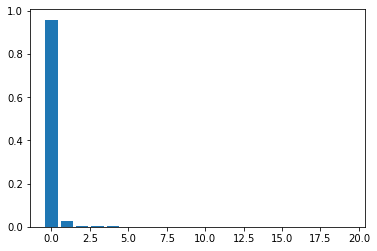

In [16]:
pca = PCA()
x_train_pca = pca.fit_transform(x_train)
cvar_arr = pca.explained_variance_ratio_
plt.bar(np.arange(0, cvar_arr.shape[0]),cvar_arr)
#pca1 or 2 are enguph

In [17]:
cvar_arr[:5]

array([0.95983799, 0.02755515, 0.00466452, 0.00408128, 0.00172212])

In [3]:
def add_print_model(name,train_pred,test_pred):
    models.append({'name':name,'train predictin score':train_pred,'test prediction score':test_pred})
    print(models[-1])


### Linear Regression

In [19]:
pca_regr = PCA(n_components=5)
pca_regr.fit(x_train)
x_train_pca = pca_regr.transform(x_train_normalize)
x_test_pca = pca_regr.transform(x_test_normalize)

C:\Users\ahmed\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
C:\Users\ahmed\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [20]:
lr_model = LinearRegression()
lr_model.fit(x_train,y_train)
lr_train_score = np.sqrt(mean_squared_error(y_train,lr_model.predict(x_train)))
lr_test_score = np.sqrt(mean_squared_error(y_test,lr_model.predict(x_test)))
add_print_model('LinearRegression',lr_train_score,lr_test_score)

{'name': 'LinearRegression', 'train predictin score': 36.53691227617429, 'test prediction score': 33.04852878254421}


### DecisionTreeRegressor

In [21]:
dtr_model =DecisionTreeRegressor(max_depth=5,min_samples_split=3)
dtr_model = dtr_model.fit(x_train, y_train)
dtr_train_score = np.sqrt(mean_squared_error(y_train,dtr_model.predict(x_train)))
dtr_test_score = np.sqrt(mean_squared_error(y_test,dtr_model.predict(x_test)))
add_print_model('DecisionTreeRegressor',dtr_train_score,dtr_test_score)

{'name': 'DecisionTreeRegressor', 'train predictin score': 35.307343463697286, 'test prediction score': 34.88881477895943}


### Bagging Regressor

In [22]:
bgging_model =BaggingRegressor(n_estimators = 100,n_jobs=-1,base_estimator=DecisionTreeRegressor(max_depth=5,min_samples_split=3))
bgging_model = bgging_model.fit(x_train, y_train)
bgging_train_score = np.sqrt(mean_squared_error(y_train,bgging_model.predict(x_train)))
bgging_test_score = np.sqrt(mean_squared_error(y_test,bgging_model.predict(x_test)))
add_print_model('BaggingRegressor_DecisionTree',bgging_train_score,bgging_test_score)

{'name': 'BaggingRegressor_DecisionTree', 'train predictin score': 34.316817297337316, 'test prediction score': 33.54175425459841}


In [23]:
bgging_model =BaggingRegressor(n_estimators = 10,n_jobs=-1,base_estimator=SVR())
bgging_model = bgging_model.fit(x_train, y_train)
bgging_train_score = np.sqrt(mean_squared_error(y_train,bgging_model.predict(x_train)))
bgging_test_score = np.sqrt(mean_squared_error(y_test,bgging_model.predict(x_test)))
add_print_model('BaggingRegressor_svr',bgging_train_score,bgging_test_score)

### RandomForestRegressor

In [24]:
rfr_model =RandomForestRegressor(n_estimators=50,min_samples_split=2,n_jobs=-1,max_depth=7)
rfr_model = rfr_model.fit(x_train, y_train)
rfr_train_score = np.sqrt(mean_squared_error(y_train,rfr_model.predict(x_train)))
rfr_test_score = np.sqrt(mean_squared_error(y_test,rfr_model.predict(x_test)))
add_print_model('RandomForestRegressor',rfr_train_score,rfr_test_score)
#

{'name': 'RandomForestRegressor', 'train predictin score': 30.962103869033683, 'test prediction score': 32.839200869970455}


### Boosting

#### Gradient Boosted Trees
XGBoost is a scalable and highly accurate implementation of gradient boosting

In [20]:
xgboost = XGBRegressor(learning_rate=0.001,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)
xgb_model = xgboost.fit(x_train, y_train)
xgb_train_score = np.sqrt(mean_squared_error(y_train,xgb_model.predict(x_train)))
xgb_test_score = np.sqrt(mean_squared_error(y_test,xgb_model.predict(x_test)))
add_print_model('xgboost',xgb_train_score,xgb_test_score)

{'name': 'xgboost', 'train predictin score': 31.664505864785454, 'test prediction score': 32.26583811923277}


### Adaboost 

In [26]:
adaboost_model =AdaBoostRegressor(n_estimators = 50,learning_rate=0.1,base_estimator=DecisionTreeRegressor(max_depth=5,min_samples_split=3))
adaboost_model = adaboost_model.fit(x_train, y_train)
adaboost_train_score = np.sqrt(mean_squared_error(y_train,adaboost_model.predict(x_train)))
adaboost_test_score = np.sqrt(mean_squared_error(y_test,adaboost_model.predict(x_test)))
add_print_model('AdaBoostRegressor_DecisionTree',adaboost_train_score,adaboost_test_score)

{'name': 'AdaBoostRegressor_DecisionTree', 'train predictin score': 34.14078729368063, 'test prediction score': 33.21472805187337}


In [27]:
adaboost_model =AdaBoostRegressor(n_estimators = 10,learning_rate=0.1,base_estimator=SVR())
adaboost_model = adaboost_model.fit(x_train, y_train)
adaboost_train_score = np.sqrt(mean_squared_error(y_train,adaboost_model.predict(x_train)))
adaboost_test_score = np.sqrt(mean_squared_error(y_test,adaboost_model.predict(x_test)))
add_print_model('AdaBoostRegressor_svr',adaboost_train_score,adaboost_test_score)
#it was slowest one and lowest acc

{'name': 'AdaBoostRegressor_svr', 'train predictin score': 48.233659979352446, 'test prediction score': 42.47254634075796}


In [34]:
models_df = pd.DataFrame(models)
models_df.to_csv('models_result.csv')
models_df

,name,train predictin score,test prediction score
0,LinearRegression,36.536912,33.048529
1,DecisionTreeRegressor,35.307343,34.888815
2,BaggingRegressor_DecisionTree,34.316817,33.541754
3,BaggingRegressor_svr,48.584084,42.811857
4,RandomForestRegressor,30.962104,32.839201
5,xgboost,31.664506,32.265838
6,AdaBoostRegressor_DecisionTree,34.140787,33.214728
7,AdaBoostRegressor_svr,48.233660,42.472546


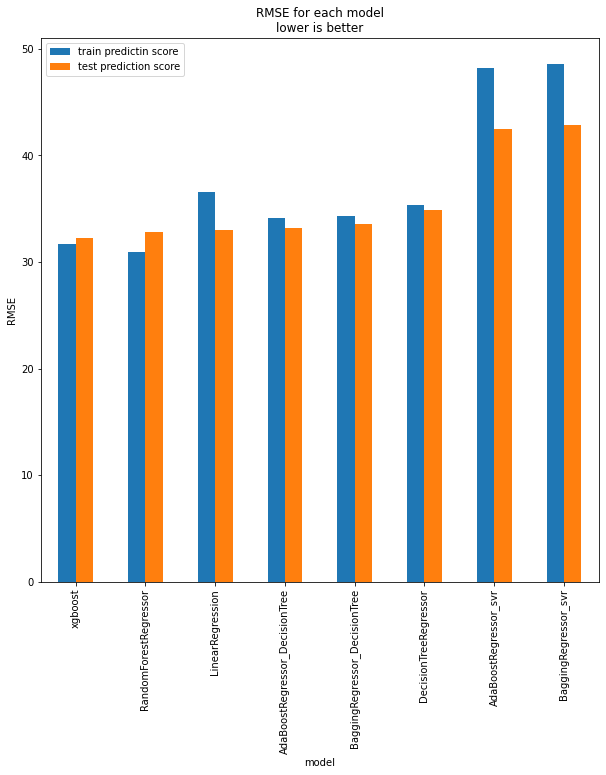

In [35]:

models_df.set_index('name').sort_values(by=['test prediction score']).plot(kind='bar',figsize=(10,10))
plt.ylabel('RMSE')
plt.xlabel('model')
plt.title('RMSE for each model\nlower is better')
plt.show()

In [30]:
#best model is xgboost with train acc = 31.66 and val acc = 32.26

# testing The model 
test model with test_airbnb_berlin csv file

## Dataframe Preprocessing Pipline

In [21]:
def dataframePip(df):

    '''
    df :pandsa data frame with columns structure same as : 
    ['Listing ID', 'Listing Name', 'Host ID', 'Host Name', 'Host Since',
       'Host Response Time', 'Host Response Rate', 'Is Superhost',
       'neighbourhood', 'Neighborhood Group', 'City', 'Postal Code',
       'Country Code', 'Country', 'Latitude', 'Longitude', 'Is Exact Location',
       'Property Type', 'Room Type', 'Accomodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Square Feet', 'Guests Included', 'Min Nights', 'Reviews',
       'First Review', 'Last Review', 'Overall Rating', 'Accuracy Rating',
       'Cleanliness Rating', 'Checkin Rating', 'Communication Rating',
       'Location Rating', 'Value Rating', 'Instant Bookable',
       'Business Travel Ready']
    
    output : return clean dataframe for model prediction 
    '''
    df = df.copy()
    df.set_index('Listing ID',inplace=True,drop=True)
    #drop unneeded columns in prediction
    removal_columns =['Listing Name','Host ID','Host Name','neighbourhood',
                    'City','Country Code','Country' ,'Host Since' ,'First Review','Last Review',
                    'Business Travel Ready','Host Response Time','Host Response Rate','Postal Code','Is Exact Location',
                    'Min Nights','Square Feet']
    df.drop(columns=removal_columns,inplace=True)

    #drop empty row  
    #i can't fill with mean beacuse therer is many missing in that coulumns
    df.dropna(subset=['Overall Rating','Accuracy Rating', 'Cleanliness Rating', 'Checkin Rating', 'Communication Rating', 'Location Rating', 'Value Rating'],inplace=True,how='all')


    #replace numerical columns missing data with tha median
    for col in df.columns:
        df[col].replace('*',np.nan,inplace=True)
        # df[col].replace('Other',np.nan,inplace=True)
    to_num_col =['Bathrooms','Bedrooms','Guests Included','Beds','Accomodates']
    for c in to_num_col:
        df[c]=pd.to_numeric(df[c], downcast="float")

    df.fillna(df.median(), inplace=True)
                            
    df['Room Type'] = df['Room Type'].replace('Shared room','Private room')  

    #nominal data is  :Neighborhood Group,Property Type , Room Type ,Instant Bookable ,Is Superhost

    df.fillna(0,inplace=True)

    #loading label classes which stored in pickel
    #load encoders in dataframe
    try:
        shost_enc = pkl.load(open('encoders/Superhost.pkl','rb'))
        neighborhood_enc =pkl.load(open('encoders/Neighborhood.pkl','rb'))
        property_enc =pkl.load(open('encoders/Property.pkl','rb'))
        room_enc =pkl.load(open('encoders/Room.pkl','rb'))
        bookable_enc =pkl.load(open('encoders/Bookable.pkl','rb'))


        df['Is Superhost'] = shost_enc.transform(df['Is Superhost'].astype(str))

        df['Neighborhood Group'] = neighborhood_enc.transform(df['Neighborhood Group'].astype(str))

        df['Property Type'] = property_enc.transform(df['Property Type'].astype(str))

        df['Room Type'] = room_enc.transform(df['Room Type'].astype(str))

        df['Instant Bookable'] = bookable_enc.transform(df['Instant Bookable'].astype(str))
        return df
    except NameError :
        
        return None
    



## data Preprocessing Pipline
not in format of data frame

In [22]:
def dataPipe(dataarray):
    '''
    dataarray : columns in shape of structure as follow:
    ['Is Superhost', 'Neighborhood Group', 'Latitude', 'Longitude',
       'Property Type', 'Room Type', 'Accomodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Guests Included', 'Reviews', 'Overall Rating',
       'Accuracy Rating', 'Cleanliness Rating', 'Checkin Rating',
       'Communication Rating', 'Location Rating', 'Value Rating',
       'Instant Bookable']

    output clean data ready for model prediction 
    '''
    try:
        shost_enc = pkl.load(open('encoders/Superhost.pkl','rb'))
        neighborhood_enc =pkl.load(open('encoders/Neighborhood.pkl','rb'))
        property_enc =pkl.load(open('encoders/Property.pkl','rb'))
        room_enc =pkl.load(open('encoders/Room.pkl','rb'))
        bookable_enc =pkl.load(open('encoders/Bookable.pkl','rb'))

        # ['Is Superhost' 0, 'Neighborhood Group' 1, 'Property Type' 4, 'Room Type' 5,'Instant Bookable' 19]

        dataarray[:,0] = shost_enc.transform(dataarray[:,0].astype(str))

        dataarray[:,1] = neighborhood_enc.transform(dataarray[:,1].astype(str))

        dataarray[:,4] = property_enc.transform(dataarray[:,4].astype(str))

        dataarray[:,5] = room_enc.transform(dataarray[:,5].astype(str))

        dataarray[:,19] = bookable_enc.transform(dataarray[:,19].astype(str))
        return dataarray.astype('float')
    except NameError :
        
        return None

### test data frame prediction

In [23]:
test_df = pd.read_csv('test_airbnb_berlin.csv')
test_df = dataframePip(test_df)

C:\Users\ahmed\AppData\Local\Temp\ipykernel_16040\1276562563.py:40: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.median(), inplace=True)


In [24]:
test_df

,Is Superhost,Neighborhood Group,Latitude,Longitude,Property Type,Room Type,Accomodates,Bathrooms,Bedrooms,Beds,Guests Included,Reviews,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Instant Bookable
Listing ID,,,,,,,,,,,,,,,,,,,,
13338017.0,2,1,52.50053,13.44184,1,0,2.0,1.0,1.0,1.0,2.0,131,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0
2899239.0,1,1,52.51647,13.45862,1,0,4.0,1.5,2.0,4.0,2.0,22,75.0,8.0,5.0,8.0,8.0,9.0,7.0,0
441586.0,1,1,52.52481,13.44676,1,1,2.0,1.0,1.0,2.0,1.0,20,94.0,10.0,9.0,10.0,9.0,9.0,9.0,1
19036720.0,1,10,52.46009,13.42204,1,1,3.0,1.0,3.0,4.0,1.0,19,96.0,10.0,10.0,10.0,10.0,9.0,9.0,1
8656349.0,1,0,52.49952,13.32903,1,0,3.0,2.0,2.0,2.0,2.0,19,91.0,10.0,9.0,10.0,10.0,9.0,10.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23369807.0,2,0,52.50378,13.31480,1,1,2.0,1.5,1.0,2.0,1.0,84,96.0,10.0,10.0,10.0,10.0,10.0,9.0,1
2861405.0,1,10,52.48460,13.35230,1,0,3.0,1.0,1.0,2.0,1.0,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0
28239659.0,2,6,52.54390,13.42881,1,0,4.0,1.0,1.0,2.0,2.0,30,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0


In [28]:
pred_price = pd.DataFrame(xgb_model.predict(test_df.values),index=test_df.index)
pred_price = pred_price.rename(columns={0:'predicted_price'})
pred_price.to_csv('predicted_price.csv')
pred_price.head()

,predicted_price
Listing ID,
13338017.0,68.384537
2899239.0,98.793175
441586.0,40.092072
19036720.0,64.677467
8656349.0,129.119370


### predict custom data 

In [26]:
test_data = np.array([['t' , 'Friedrichshain-Kreuzberg' ,52.50053,13.44184,'Apartment' , 'Entire home/apt' ,
2. , 1. , 1. , 1. , 2. , 131. , 97. ,10. ,10. ,10. ,10. ,10. , 10. , 'f' ],
 ['f' , 'Friedrichshain-Kreuzberg' ,52.51647,13.45862, 'Apartment' , 'Entire home/apt' ,4. , 1.5, 2. , 4. , 2. ,22. , 75. ,
  8. , 5. , 8. , 8. , 9. ,7. , 'f' ]])
test_data = dataPipe(test_data)
test_data
  

array([[  2.     ,   1.     ,  52.50053,  13.44184,   1.     ,   0.     ,
          2.     ,   1.     ,   1.     ,   1.     ,   2.     , 131.     ,
         97.     ,  10.     ,  10.     ,  10.     ,  10.     ,  10.     ,
         10.     ,   0.     ],
       [  1.     ,   1.     ,  52.51647,  13.45862,   1.     ,   0.     ,
          4.     ,   1.5    ,   2.     ,   4.     ,   2.     ,  22.     ,
         75.     ,   8.     ,   5.     ,   8.     ,   8.     ,   9.     ,
          7.     ,   0.     ]])

In [27]:
xgb_model.predict(test_data)

array([68.38454 , 98.793175], dtype=float32)

In [32]:
print(pred_price.iloc[:2,0].values)

[68.38454  98.793175]
